Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 596 kB 73.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4df9f73fca74da767551cf8557626dd16ecaea9d7cfea71f145a04998bc7fb0e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['I-Condition-Unit', 'B-Condition-Unit', 'I-Characterization-Apparatus', 'I-Material', 'O', 'B-Condition-Misc', 'B-Property-Unit', 'I-Nonrecipe-Material', 'I-Condition-Type', 'I-Amount-Misc', 'B-Synthesis-Apparatus', 'I-Property-Unit', 'I-Apparatus-Descriptor', 'I-Property-Type', 'I-Synthesis-Apparatus', 'B-Property-Type', 'I-Apparatus-Property-Type', 'B-Amount-Misc', 'I-Brand', 'B-Condition-Type', 'B-Brand', 'I-Operation', 'B-Apparatus-Unit', 'B-Reference', 'I-Meta', 'I-Apparatus-Unit', 'I-Number', 'B-Meta', 'B-Apparatus-Property-Type', 'B-Operation', 'I-Material-Descriptor', 'B-Amount-Unit', 'B-Number', 'B-Material', 'B-Material-Descriptor', 'B-Apparatus-Descriptor', 'I-Condition-Misc', 'I-Property-Misc', 'I-Amount-Unit', 'B-Nonr

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

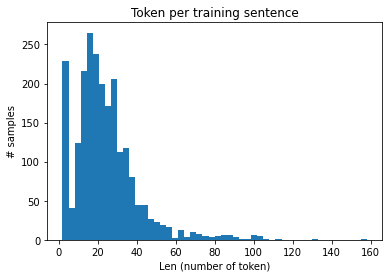

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

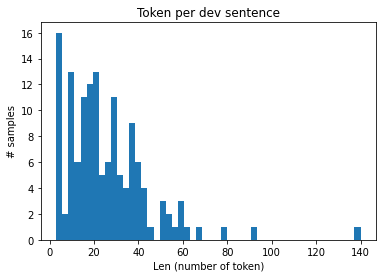

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

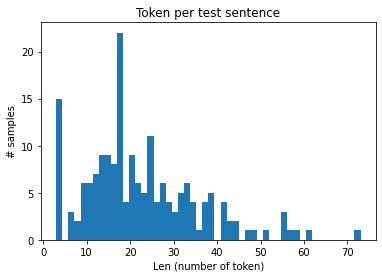

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

3714
PEG
33
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.778)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 500
Points in y_train before removal: 500


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[5073, 4221, 5957]
[4, 4, 4]
[5073, 4221, 3707]
[4, 4, 4]
[5073, 4221, 4508]
[4, 4, 4]
3714
PEG
33
O
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 12.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.7 MB/s 
     |████████████████████████████████| 120 kB 42.6 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e8124cda59f64159fefb97fee33e47567ea28fc6826bcf8c1df8bc1c8505b749
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[5073, 4221, 5957]
[4, 4, 4]
[5073, 4221, 3707]
[4, 4, 4]


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9918389320373535
Training loss epoch: 1.673465371131897
Training accuracy epoch: 0.6363963900519364
Validating model...
Validation Loss: 0.9563551545143127
Validation Accuracy: 0.7704747007125048
Training epoch: 2
Training loss per 100 training steps: 0.9998505115509033
Training loss epoch: 0.7337243229150772
Training accuracy epoch: 0.820126839437045
Validating model...
Validation Loss: 0.6857409656047821
Validation Accuracy: 0.8292913270971434
Training epoch: 3
Training loss per 100 training steps: 0.5188793540000916
Training loss epoch: 0.46783184707164766
Training accuracy epoch: 0.8759467826042636
Validating model...
Validation Loss: 0.5877991557121277
Validation Accuracy: 0.8496846358513327
Training epoch: 4
Training loss per 100 training steps: 0.3734499216079712
Training loss epoch: 0.31554988622665403
Training accuracy epoch: 0.9152969138514587
Validating model...
Validation Loss: 0.5376382440328598
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.579604834318161
Validation Accuracy: 0.8495521850764151
Validation duration: 0.021033316666666715 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.83      0.93      0.87        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.69      0.74      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.68      0.91      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.991039991378784
Training loss epoch: 1.641887354850769
Training accuracy epoch: 0.633780509687606
Validating model...
Validation Loss: 0.9822280645370484
Validation Accuracy: 0.7608596487918401
Training epoch: 2
Training loss per 100 training steps: 0.9220510721206665
Training loss epoch: 0.7653356730937958
Training accuracy epoch: 0.8145372243256566
Validating model...
Validation Loss: 0.7022454679012299
Validation Accuracy: 0.8272528053089389
Training epoch: 3
Training loss per 100 training steps: 0.4775776267051697
Training loss epoch: 0.5002257242798805
Training accuracy epoch: 0.8698590552786578
Validating model...
Validation Loss: 0.5773156404495239
Validation Accuracy: 0.842562291248772
Training epoch: 4
Training loss per 100 training steps: 0.3991279602050781
Training loss epoch: 0.3369801051914692
Training accuracy epoch: 0.9067545296142404
Validating model...
Validation Loss: 0.5627373814582824
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6029798663579501
Validation Accuracy: 0.8507836628651587
Validation duration: 0.02112976666666668 minutes
F1-score (test): 76.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.78      0.91      0.84        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.71      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.793016195297241
Training loss epoch: 1.629663074016571
Training accuracy epoch: 0.639558032072568
Validating model...
Validation Loss: 0.9147832512855529
Validation Accuracy: 0.774755189752361
Training epoch: 2
Training loss per 100 training steps: 0.8550136685371399
Training loss epoch: 0.7240409851074219
Training accuracy epoch: 0.8180772503329834
Validating model...
Validation Loss: 0.7105111718177796
Validation Accuracy: 0.8250769060538807
Training epoch: 3
Training loss per 100 training steps: 0.5373759269714355
Training loss epoch: 0.5001965925097466
Training accuracy epoch: 0.8704398186680422
Validating model...
Validation Loss: 0.5747978001832962
Validation Accuracy: 0.8451410019293437
Training epoch: 4
Training loss per 100 training steps: 0.3995855748653412
Training loss epoch: 0.3400403015315533
Training accuracy epoch: 0.9075031385754642
Validating model...
Validation Loss: 0.5668636202812195
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6099663147559533
Validation Accuracy: 0.8491913303956042
Validation duration: 0.020882283333333855 minutes
F1-score (test): 75.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.82      0.92      0.87        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.70      0.88      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.531374931335449
Training loss epoch: 1.5854509800672532
Training accuracy epoch: 0.6553247683779693
Validating model...
Validation Loss: 0.9237024784088135
Validation Accuracy: 0.7733993132683603
Training epoch: 2
Training loss per 100 training steps: 0.8418706655502319
Training loss epoch: 0.7022032707929611
Training accuracy epoch: 0.827846648818501
Validating model...
Validation Loss: 0.6924651145935059
Validation Accuracy: 0.824674679493327
Training epoch: 3
Training loss per 100 training steps: 0.46201804280281067
Training loss epoch: 0.4747074440121651
Training accuracy epoch: 0.87437069262101
Validating model...
Validation Loss: 0.5634400486946106
Validation Accuracy: 0.8502377324243998
Training epoch: 4
Training loss per 100 training steps: 0.3830101490020752
Training loss epoch: 0.31995872408151627
Training accuracy epoch: 0.9117898294131359
Validating model...
Validation Loss: 0.5288528800010681
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5556176992563101
Validation Accuracy: 0.8483254172727945
Validation duration: 0.02121056666666732 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.90      0.82        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.58      0.70      0.63        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.99      0.92        87
                  Material       0.70      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.913799285888672
Training loss epoch: 1.6470757663249969
Training accuracy epoch: 0.6355063588420657
Validating model...
Validation Loss: 0.9052728772163391
Validation Accuracy: 0.7784188612651024
Training epoch: 2
Training loss per 100 training steps: 0.9450743198394775
Training loss epoch: 0.7155172005295753
Training accuracy epoch: 0.8210734172790595
Validating model...
Validation Loss: 0.6612358808517456
Validation Accuracy: 0.8320029272143767
Training epoch: 3
Training loss per 100 training steps: 0.5698040723800659
Training loss epoch: 0.4573946237564087
Training accuracy epoch: 0.8800732226105852
Validating model...
Validation Loss: 0.5739998400211335
Validation Accuracy: 0.842152456118994
Training epoch: 4
Training loss per 100 training steps: 0.4243674576282501
Training loss epoch: 0.30665983259677887
Training accuracy epoch: 0.9155063732910834
Validating model...
Validation Loss: 0.566861042380333
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6261054942241082
Validation Accuracy: 0.8390037363182448
Validation duration: 0.021063550000000455 minutes
F1-score (test): 73.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.69      0.89      0.78        98
      Apparatus-Descriptor       0.29      0.78      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.40      0.90      0.55        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.67      0.90      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.175551414489746
Training loss epoch: 1.6840522676706313
Training accuracy epoch: 0.6222029555222307
Validating model...
Validation Loss: 0.9624078929424286
Validation Accuracy: 0.7649695263704268
Training epoch: 2
Training loss per 100 training steps: 0.983788788318634
Training loss epoch: 0.7282698303461075
Training accuracy epoch: 0.820015261590106
Validating model...
Validation Loss: 0.6951517969369888
Validation Accuracy: 0.830574308277653
Training epoch: 3
Training loss per 100 training steps: 0.6002197861671448
Training loss epoch: 0.4809219390153885
Training accuracy epoch: 0.8705399516989714
Validating model...
Validation Loss: 0.6092384696006775
Validation Accuracy: 0.8383569991007491
Training epoch: 4
Training loss per 100 training steps: 0.3004654049873352
Training loss epoch: 0.3282591350376606
Training accuracy epoch: 0.9090578916451634
Validating model...
Validation Loss: 0.5924871474504471
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5788054328698379
Validation Accuracy: 0.8525479340481141
Validation duration: 0.02096941666666794 minutes
F1-score (test): 75.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.78      0.92      0.85        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.66      0.85      0.74        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.72      0.89      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.5235111713409424
Training loss epoch: 1.5598564863204956
Training accuracy epoch: 0.6502958156902499
Validating model...
Validation Loss: 0.9537986755371094
Validation Accuracy: 0.7709034428670216
Training epoch: 2
Training loss per 100 training steps: 0.971983790397644
Training loss epoch: 0.7064836978912353
Training accuracy epoch: 0.822897275633044
Validating model...
Validation Loss: 0.6533819109201431
Validation Accuracy: 0.8383456666779084
Training epoch: 3
Training loss per 100 training steps: 0.5697936415672302
Training loss epoch: 0.448562853038311
Training accuracy epoch: 0.8770129599665817
Validating model...
Validation Loss: 0.5866809338331223
Validation Accuracy: 0.8430970407643384
Training epoch: 4
Training loss per 100 training steps: 0.39966022968292236
Training loss epoch: 0.29980218410491943
Training accuracy epoch: 0.9170521284546147
Validating model...
Validation Loss: 0.5074259608983993
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5713337132563958
Validation Accuracy: 0.8510849354233966
Validation duration: 0.020794816666667278 minutes
F1-score (test): 75.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.90      0.80        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.57      0.78      0.66        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.85      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.72      0.89      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.830345630645752
Training loss epoch: 1.6410419046878815
Training accuracy epoch: 0.6365888817009335
Validating model...
Validation Loss: 0.9244682490825653
Validation Accuracy: 0.7760191485518769
Training epoch: 2
Training loss per 100 training steps: 1.033897876739502
Training loss epoch: 0.7415772706270218
Training accuracy epoch: 0.8193908666718096
Validating model...
Validation Loss: 0.7106674492359162
Validation Accuracy: 0.8297153683690471
Training epoch: 3
Training loss per 100 training steps: 0.48474669456481934
Training loss epoch: 0.4877623274922371
Training accuracy epoch: 0.8720148493840554
Validating model...
Validation Loss: 0.6104588717222214
Validation Accuracy: 0.8325825452625335
Training epoch: 4
Training loss per 100 training steps: 0.3738170564174652
Training loss epoch: 0.32535096257925034
Training accuracy epoch: 0.9119266751605061
Validating model...
Validation Loss: 0.5601852089166641
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6836135066472567
Validation Accuracy: 0.8337850330248783
Validation duration: 0.020957233333333155 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.33      0.18      0.24        11
            Condition-Misc       0.45      0.95      0.61        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.71      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.729792356491089
Training loss epoch: 1.5791856199502945
Training accuracy epoch: 0.6495427681745277
Validating model...
Validation Loss: 0.9154621839523316
Validation Accuracy: 0.7828886805315809
Training epoch: 2
Training loss per 100 training steps: 0.7461375594139099
Training loss epoch: 0.7173375368118287
Training accuracy epoch: 0.823716178284287
Validating model...
Validation Loss: 0.6789027333259583
Validation Accuracy: 0.8240873782625304
Training epoch: 3
Training loss per 100 training steps: 0.42806923389434814
Training loss epoch: 0.458338725566864
Training accuracy epoch: 0.876891904755903
Validating model...
Validation Loss: 0.5736535400152206
Validation Accuracy: 0.8429922825977998
Training epoch: 4
Training loss per 100 training steps: 0.3348207175731659
Training loss epoch: 0.3022535502910614
Training accuracy epoch: 0.9186175118984234
Validating model...
Validation Loss: 0.5705577522516251
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6040216386318207
Validation Accuracy: 0.8442631590569357
Validation duration: 0.0208059333333343 minutes
F1-score (test): 74.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.70      0.90      0.79        98
      Apparatus-Descriptor       0.31      0.89      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.53      0.85      0.65        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.85      0.97      0.90        87
                  Material       0.69      0.89      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7287986278533936
Training loss epoch: 1.591761189699173
Training accuracy epoch: 0.652775447582502
Validating model...
Validation Loss: 0.9696310997009278
Validation Accuracy: 0.7646881095952186
Training epoch: 2
Training loss per 100 training steps: 0.7413440346717834
Training loss epoch: 0.7288498848676681
Training accuracy epoch: 0.8224262772059511
Validating model...
Validation Loss: 0.6754615038633347
Validation Accuracy: 0.8221861334189458
Training epoch: 3
Training loss per 100 training steps: 0.49279242753982544
Training loss epoch: 0.4692676723003387
Training accuracy epoch: 0.8736620435914535
Validating model...
Validation Loss: 0.5786675393581391
Validation Accuracy: 0.8394750210402113
Training epoch: 4
Training loss per 100 training steps: 0.3898739814758301
Training loss epoch: 0.3094279199838638
Training accuracy epoch: 0.9150136311660255
Validating model...
Validation Loss: 0.5593936145305634
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5931478979495856
Validation Accuracy: 0.8464808717491695
Validation duration: 0.020799066666667917 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.86      0.94      0.90        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.20      0.18      0.19        11
            Condition-Misc       0.46      0.85      0.60        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.70      0.88      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.943530797958374
Training loss epoch: 1.6414038765998114
Training accuracy epoch: 0.638221975964469
Validating model...
Validation Loss: 0.9286393105983735
Validation Accuracy: 0.7671359979611915
Training epoch: 2
Training loss per 100 training steps: 0.7451727390289307
Training loss epoch: 0.7592378684452602
Training accuracy epoch: 0.8083490814731403
Validating model...
Validation Loss: 0.680398428440094
Validation Accuracy: 0.8289889643591746
Training epoch: 3
Training loss per 100 training steps: 0.45123016834259033
Training loss epoch: 0.49412818607829867
Training accuracy epoch: 0.8653855008146669
Validating model...
Validation Loss: 0.5710285097360611
Validation Accuracy: 0.8484247988438683
Training epoch: 4
Training loss per 100 training steps: 0.30801916122436523
Training loss epoch: 0.33578967125642867
Training accuracy epoch: 0.9099785342518418
Validating model...
Validation Loss: 0.5253933310508728
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5587664819680728
Validation Accuracy: 0.8490635081826496
Validation duration: 0.020861933333333128 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.78      0.92      0.84        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.62      0.90      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.97      0.91        87
                  Material       0.69      0.86      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5819201469421387
Training loss epoch: 1.5561496359961373
Training accuracy epoch: 0.6554063140211922
Validating model...
Validation Loss: 0.884937584400177
Validation Accuracy: 0.7976144380707975
Training epoch: 2
Training loss per 100 training steps: 0.8120128512382507
Training loss epoch: 0.6981482392265683
Training accuracy epoch: 0.8284558405513994
Validating model...
Validation Loss: 0.641051709651947
Validation Accuracy: 0.8389904435900055
Training epoch: 3
Training loss per 100 training steps: 0.5183345675468445
Training loss epoch: 0.45092580644857316
Training accuracy epoch: 0.8780961005219025
Validating model...
Validation Loss: 0.5667828500270844
Validation Accuracy: 0.8439380843748614
Training epoch: 4
Training loss per 100 training steps: 0.35288918018341064
Training loss epoch: 0.3056524473996389
Training accuracy epoch: 0.9157891542930382
Validating model...
Validation Loss: 0.5504684448242188
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5820978650679955
Validation Accuracy: 0.848937151563704
Validation duration: 0.02073851666666542 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.82      0.96      0.89        98
      Apparatus-Descriptor       0.35      0.78      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.74      0.85      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.705634355545044
Training loss epoch: 1.5836605174200875
Training accuracy epoch: 0.6560247480255574
Validating model...
Validation Loss: 0.9392248392105103
Validation Accuracy: 0.774317902871714
Training epoch: 2
Training loss per 100 training steps: 0.8294991254806519
Training loss epoch: 0.7100854856627328
Training accuracy epoch: 0.8200810536172275
Validating model...
Validation Loss: 0.6655798107385635
Validation Accuracy: 0.8390675150518494
Training epoch: 3
Training loss per 100 training steps: 0.6687548160552979
Training loss epoch: 0.46109554455393836
Training accuracy epoch: 0.8763705256999819
Validating model...
Validation Loss: 0.5791562795639038
Validation Accuracy: 0.8394263247769693
Training epoch: 4
Training loss per 100 training steps: 0.31953608989715576
Training loss epoch: 0.3311342199643453
Training accuracy epoch: 0.9112094015469073
Validating model...
Validation Loss: 0.5378771930932998
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5583330507461841
Validation Accuracy: 0.8483573249487624
Validation duration: 0.02080158333333581 minutes
F1-score (test): 75.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.93      0.86        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.20      0.18      0.19        11
            Condition-Misc       0.50      0.80      0.62        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.87      1.00      0.93        87
                  Material       0.72      0.89      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.894667387008667
Training loss epoch: 1.6055541066896348
Training accuracy epoch: 0.6479757871819495
Validating model...
Validation Loss: 0.9352920472621917
Validation Accuracy: 0.7728255969811156
Training epoch: 2
Training loss per 100 training steps: 0.7469605207443237
Training loss epoch: 0.7299799294698806
Training accuracy epoch: 0.8206898457383789
Validating model...
Validation Loss: 0.6839394241571426
Validation Accuracy: 0.8274148312230754
Training epoch: 3
Training loss per 100 training steps: 0.5682653784751892
Training loss epoch: 0.470725261029743
Training accuracy epoch: 0.8740865642586768
Validating model...
Validation Loss: 0.5653715521097183
Validation Accuracy: 0.8478103154530118
Training epoch: 4
Training loss per 100 training steps: 0.26163771748542786
Training loss epoch: 0.33049903880982173
Training accuracy epoch: 0.9059828921354005
Validating model...
Validation Loss: 0.5539636015892029
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5755898585686317
Validation Accuracy: 0.850321337909371
Validation duration: 0.020845516666668118 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.79      0.93      0.85        98
      Apparatus-Descriptor       0.26      0.56      0.36         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      1.00      0.94        87
                  Material       0.70      0.86      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8520216941833496
Training loss epoch: 1.590215714204879
Training accuracy epoch: 0.6456350606068225
Validating model...
Validation Loss: 0.9281738340854645
Validation Accuracy: 0.7826387485209709
Training epoch: 2
Training loss per 100 training steps: 0.9788902997970581
Training loss epoch: 0.702829490105311
Training accuracy epoch: 0.8268471400039811
Validating model...
Validation Loss: 0.6778302222490311
Validation Accuracy: 0.8285081960292263
Training epoch: 3
Training loss per 100 training steps: 0.5651921033859253
Training loss epoch: 0.46884576763425556
Training accuracy epoch: 0.8724455175508533
Validating model...
Validation Loss: 0.6352550774812699
Validation Accuracy: 0.8374667819367589
Training epoch: 4
Training loss per 100 training steps: 0.43728548288345337
Training loss epoch: 0.3404091014748528
Training accuracy epoch: 0.9099355742057911
Validating model...
Validation Loss: 0.5778654098510743
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5922703536657187
Validation Accuracy: 0.8436994838092596
Validation duration: 0.02084348333333613 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.91      0.86        98
      Apparatus-Descriptor       0.38      0.89      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.70      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.974173069000244
Training loss epoch: 1.5773086093720936
Training accuracy epoch: 0.6501324431327761
Validating model...
Validation Loss: 0.9219858586788178
Validation Accuracy: 0.7811945933404234
Training epoch: 2
Training loss per 100 training steps: 0.9125810861587524
Training loss epoch: 0.6895616324174971
Training accuracy epoch: 0.8263019117701227
Validating model...
Validation Loss: 0.6632203876972198
Validation Accuracy: 0.833692999111794
Training epoch: 3
Training loss per 100 training steps: 0.5089951157569885
Training loss epoch: 0.44534868995348614
Training accuracy epoch: 0.8813542760231443
Validating model...
Validation Loss: 0.5728069007396698
Validation Accuracy: 0.843080169191538
Training epoch: 4
Training loss per 100 training steps: 0.3252963721752167
Training loss epoch: 0.30978656453745707
Training accuracy epoch: 0.9164658248092039
Validating model...
Validation Loss: 0.5433260977268219
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5975762559817388
Validation Accuracy: 0.8429933176913317
Validation duration: 0.02083183333333333 minutes
F1-score (test): 74.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.75      0.88      0.81        98
      Apparatus-Descriptor       0.36      0.89      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.30      0.27      0.29        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.72      0.88      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.551708459854126
Training loss epoch: 1.5251807456924802
Training accuracy epoch: 0.6655182113500595
Validating model...
Validation Loss: 0.9119227349758148
Validation Accuracy: 0.781924867496592
Training epoch: 2
Training loss per 100 training steps: 0.8770167827606201
Training loss epoch: 0.6972357886178153
Training accuracy epoch: 0.8266077451803668
Validating model...
Validation Loss: 0.6326293796300888
Validation Accuracy: 0.8404471067370813
Training epoch: 3
Training loss per 100 training steps: 0.5193564295768738
Training loss epoch: 0.4417307660693214
Training accuracy epoch: 0.8817993576085941
Validating model...
Validation Loss: 0.5522698432207107
Validation Accuracy: 0.8515898307551402
Training epoch: 4
Training loss per 100 training steps: 0.3960200846195221
Training loss epoch: 0.29463976266838254
Training accuracy epoch: 0.9190502375150768
Validating model...
Validation Loss: 0.5435976654291153
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.615318429011565
Validation Accuracy: 0.8485204996013805
Validation duration: 0.020937066666666244 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.40      0.57      0.47         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.85      0.63        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.71      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.92693829536438
Training loss epoch: 1.5838846393993922
Training accuracy epoch: 0.651375011830091
Validating model...
Validation Loss: 0.8906951606273651
Validation Accuracy: 0.7828628705596585
Training epoch: 2
Training loss per 100 training steps: 0.9402027130126953
Training loss epoch: 0.6683969526063829
Training accuracy epoch: 0.8337326737966347
Validating model...
Validation Loss: 0.6539218604564667
Validation Accuracy: 0.8331790261991319
Training epoch: 3
Training loss per 100 training steps: 0.4903262257575989
Training loss epoch: 0.44187438629922415
Training accuracy epoch: 0.8830878174311609
Validating model...
Validation Loss: 0.5755800366401672
Validation Accuracy: 0.8409318081935317
Training epoch: 4
Training loss per 100 training steps: 0.3275984823703766
Training loss epoch: 0.30348761947382064
Training accuracy epoch: 0.9175179488471763
Validating model...
Validation Loss: 0.563339501619339
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6130472627969888
Validation Accuracy: 0.8428632257878529
Validation duration: 0.02084816666666711 minutes
F1-score (test): 74.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.89      0.79        98
      Apparatus-Descriptor       0.36      0.56      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.99      0.92        87
                  Material       0.69      0.92      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.985934019088745
Training loss epoch: 1.6200460905120486
Training accuracy epoch: 0.6395409956390016
Validating model...
Validation Loss: 0.919789832830429
Validation Accuracy: 0.7688422699405674
Training epoch: 2
Training loss per 100 training steps: 0.8305062055587769
Training loss epoch: 0.7347880545116606
Training accuracy epoch: 0.8134870682599691
Validating model...
Validation Loss: 0.6888420581817627
Validation Accuracy: 0.8330082358625173
Training epoch: 3
Training loss per 100 training steps: 0.5516627430915833
Training loss epoch: 0.4886929307665144
Training accuracy epoch: 0.8705560102418597
Validating model...
Validation Loss: 0.5506420224905014
Validation Accuracy: 0.8546818036469201
Training epoch: 4
Training loss per 100 training steps: 0.4152000844478607
Training loss epoch: 0.34974611018385204
Training accuracy epoch: 0.8998939900410976
Validating model...
Validation Loss: 0.5598544925451279
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5826329795213846
Validation Accuracy: 0.8391698125815353
Validation duration: 0.020910749999999704 minutes
F1-score (test): 73.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.73      0.92      0.81        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      0.80      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.99      0.92        87
                  Material       0.69      0.85      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.929089069366455
Training loss epoch: 1.5766395926475525
Training accuracy epoch: 0.652940588883606
Validating model...
Validation Loss: 0.9080554246902466
Validation Accuracy: 0.7864745749730095
Training epoch: 2
Training loss per 100 training steps: 0.8039439916610718
Training loss epoch: 0.7056362004507155
Training accuracy epoch: 0.8268425117088731
Validating model...
Validation Loss: 0.6999878376722336
Validation Accuracy: 0.8247493011703003
Training epoch: 3
Training loss per 100 training steps: 0.45600369572639465
Training loss epoch: 0.4592618431363787
Training accuracy epoch: 0.8767951703673634
Validating model...
Validation Loss: 0.5658622771501541
Validation Accuracy: 0.8460343478418562
Training epoch: 4
Training loss per 100 training steps: 0.3917418420314789
Training loss epoch: 0.3033465665011179
Training accuracy epoch: 0.9163664647218285
Validating model...
Validation Loss: 0.5896508395671844
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5964418237025921
Validation Accuracy: 0.836517872208967
Validation duration: 0.02073886666666264 minutes
F1-score (test): 73.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.94      0.87        98
      Apparatus-Descriptor       0.17      0.33      0.22         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       0.12      0.09      0.11        11
            Condition-Misc       0.42      0.75      0.54        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.83      0.98      0.90        87
                  Material       0.66      0.87      0.75       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.740043878555298
Training loss epoch: 1.4492483933766682
Training accuracy epoch: 0.672434666008657
Validating model...
Validation Loss: 0.8448140740394592
Validation Accuracy: 0.8004131708876262
Training epoch: 2
Training loss per 100 training steps: 0.9089395999908447
Training loss epoch: 0.6563751734793186
Training accuracy epoch: 0.8365225141503156
Validating model...
Validation Loss: 0.6523561894893646
Validation Accuracy: 0.8331644346215624
Training epoch: 3
Training loss per 100 training steps: 0.4621579945087433
Training loss epoch: 0.4053516760468483
Training accuracy epoch: 0.8895788781057665
Validating model...
Validation Loss: 0.5252632081508637
Validation Accuracy: 0.8556400015743085
Training epoch: 4
Training loss per 100 training steps: 0.2969439625740051
Training loss epoch: 0.2553694148858388
Training accuracy epoch: 0.929918699591345
Validating model...
Validation Loss: 0.5595949321985245
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.55511841407189
Validation Accuracy: 0.8464100433042188
Validation duration: 0.02063696666667359 minutes
F1-score (test): 73.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.79      0.95      0.86        98
      Apparatus-Descriptor       0.36      0.56      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      0.85      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.82      0.97      0.89        87
                  Material       0.67      0.87      0.76       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8294332027435303
Training loss epoch: 1.4730998252828915
Training accuracy epoch: 0.672536355410978
Validating model...
Validation Loss: 0.876599258184433
Validation Accuracy: 0.7946401100332532
Training epoch: 2
Training loss per 100 training steps: 0.872624933719635
Training loss epoch: 0.6593363744517168
Training accuracy epoch: 0.8331323942151115
Validating model...
Validation Loss: 0.604481253027916
Validation Accuracy: 0.8422953232961531
Training epoch: 3
Training loss per 100 training steps: 0.4235302209854126
Training loss epoch: 0.4194374531507492
Training accuracy epoch: 0.8888381050504458
Validating model...
Validation Loss: 0.5108191847801209
Validation Accuracy: 0.8607425137860089
Training epoch: 4
Training loss per 100 training steps: 0.4042273461818695
Training loss epoch: 0.2815289478749037
Training accuracy epoch: 0.9242809309840564
Validating model...
Validation Loss: 0.5165450185537338
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5826292175513047
Validation Accuracy: 0.8392848099458553
Validation duration: 0.02075885000000047 minutes
F1-score (test): 73.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.74      0.91      0.82        98
      Apparatus-Descriptor       0.31      0.56      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.90      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.97      0.90        87
                  Material       0.67      0.87      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.06352424621582
Training loss epoch: 1.5122620835900307
Training accuracy epoch: 0.6612493043708644
Validating model...
Validation Loss: 0.8571495711803436
Validation Accuracy: 0.7927308623747594
Training epoch: 2
Training loss per 100 training steps: 0.761051595211029
Training loss epoch: 0.6444544903934002
Training accuracy epoch: 0.8386579828488184
Validating model...
Validation Loss: 0.5988590151071549
Validation Accuracy: 0.8483717701371596
Training epoch: 3
Training loss per 100 training steps: 0.4214608073234558
Training loss epoch: 0.4007156789302826
Training accuracy epoch: 0.8933647409969536
Validating model...
Validation Loss: 0.5224078506231308
Validation Accuracy: 0.8596596251271595
Training epoch: 4
Training loss per 100 training steps: 0.26938536763191223
Training loss epoch: 0.24831493074695268
Training accuracy epoch: 0.9330647968353816
Validating model...
Validation Loss: 0.5107496947050094
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5780382614869338
Validation Accuracy: 0.8453539608721929
Validation duration: 0.022384299999998802 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.82      0.95      0.88        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.57      0.85      0.68        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.70      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7505722045898438
Training loss epoch: 1.4733849292000134
Training accuracy epoch: 0.6723501801464015
Validating model...
Validation Loss: 0.8318547666072845
Validation Accuracy: 0.8021274306096219
Training epoch: 2
Training loss per 100 training steps: 0.8932343125343323
Training loss epoch: 0.6382062087456385
Training accuracy epoch: 0.8418779647759423
Validating model...
Validation Loss: 0.6421138197183609
Validation Accuracy: 0.8323150556650786
Training epoch: 3
Training loss per 100 training steps: 0.4759396016597748
Training loss epoch: 0.40530799329280853
Training accuracy epoch: 0.8901699518743623
Validating model...
Validation Loss: 0.5706300377845764
Validation Accuracy: 0.8499095575202394
Training epoch: 4
Training loss per 100 training steps: 0.32042068243026733
Training loss epoch: 0.2596736227472623
Training accuracy epoch: 0.929964841918402
Validating model...
Validation Loss: 0.5803757309913635
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6101004848113427
Validation Accuracy: 0.8498333364214887
Validation duration: 0.02213411666666616 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.80      0.90      0.85        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.73      0.84      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.05941104888916
Training loss epoch: 1.5086689367890358
Training accuracy epoch: 0.6688134680776172
Validating model...
Validation Loss: 0.9356980919837952
Validation Accuracy: 0.7773582797792719
Training epoch: 2
Training loss per 100 training steps: 0.7415807843208313
Training loss epoch: 0.6712235373755296
Training accuracy epoch: 0.8326874130955666
Validating model...
Validation Loss: 0.6977594017982482
Validation Accuracy: 0.8272501435820889
Training epoch: 3
Training loss per 100 training steps: 0.37617194652557373
Training loss epoch: 0.4391833283007145
Training accuracy epoch: 0.8813269204757569
Validating model...
Validation Loss: 0.5814288109540939
Validation Accuracy: 0.8452698082714629
Training epoch: 4
Training loss per 100 training steps: 0.2880546450614929
Training loss epoch: 0.2798034728815158
Training accuracy epoch: 0.9243458789251746
Validating model...
Validation Loss: 0.5621737718582154
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6089468873464144
Validation Accuracy: 0.848737883840741
Validation duration: 0.02078743333333174 minutes
F1-score (test): 76.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.84      0.94      0.88        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.57      0.85      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.72      0.85      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.758762836456299
Training loss epoch: 1.49281345307827
Training accuracy epoch: 0.6637328220488831
Validating model...
Validation Loss: 0.8419969379901886
Validation Accuracy: 0.7964083864310748
Training epoch: 2
Training loss per 100 training steps: 0.8324729204177856
Training loss epoch: 0.6411185711622238
Training accuracy epoch: 0.838543385220535
Validating model...
Validation Loss: 0.6267931878566741
Validation Accuracy: 0.8395768917606725
Training epoch: 3
Training loss per 100 training steps: 0.5339011549949646
Training loss epoch: 0.40147896111011505
Training accuracy epoch: 0.8917445226760924
Validating model...
Validation Loss: 0.5636219441890716
Validation Accuracy: 0.8457109070192281
Training epoch: 4
Training loss per 100 training steps: 0.301982581615448
Training loss epoch: 0.2559217804421981
Training accuracy epoch: 0.9313992200981399
Validating model...
Validation Loss: 0.5420381277799606
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.617807713838724
Validation Accuracy: 0.8364336523161722
Validation duration: 0.02062916666666297 minutes
F1-score (test): 73.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.75      0.91      0.82        98
      Apparatus-Descriptor       0.38      0.89      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.63      0.70      0.67        27
Characterization-Apparatus       0.40      0.36      0.38        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.87      0.97      0.91        87
                  Material       0.73      0.85      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.866328001022339
Training loss epoch: 1.4869773437579472
Training accuracy epoch: 0.6710097774403602
Validating model...
Validation Loss: 0.8608358860015869
Validation Accuracy: 0.7969533478112211
Training epoch: 2
Training loss per 100 training steps: 0.760141909122467
Training loss epoch: 0.6547288944323858
Training accuracy epoch: 0.8367206044626679
Validating model...
Validation Loss: 0.6244136929512024
Validation Accuracy: 0.8380113192933738
Training epoch: 3
Training loss per 100 training steps: 0.5302877426147461
Training loss epoch: 0.4031091456611951
Training accuracy epoch: 0.8908946946920926
Validating model...
Validation Loss: 0.5445701032876968
Validation Accuracy: 0.8525134842827337
Training epoch: 4
Training loss per 100 training steps: 0.2705656886100769
Training loss epoch: 0.25618500138322514
Training accuracy epoch: 0.9302296175168921
Validating model...
Validation Loss: 0.5050390869379043
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5540544367753543
Validation Accuracy: 0.8477438352756508
Validation duration: 0.0206406999999975 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.81      0.93      0.87        98
      Apparatus-Descriptor       0.36      0.89      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.22      0.18      0.20        11
            Condition-Misc       0.61      0.85      0.71        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.70      0.85      0.77       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.604905605316162
Training loss epoch: 1.4055546124776204
Training accuracy epoch: 0.6846626335708076
Validating model...
Validation Loss: 0.8278087317943573
Validation Accuracy: 0.7983212011832606
Training epoch: 2
Training loss per 100 training steps: 0.7398399114608765
Training loss epoch: 0.6137809418141842
Training accuracy epoch: 0.8431513484130795
Validating model...
Validation Loss: 0.6078099101781845
Validation Accuracy: 0.8406491267617453
Training epoch: 3
Training loss per 100 training steps: 0.42947709560394287
Training loss epoch: 0.3694453885157903
Training accuracy epoch: 0.8990857438485486
Validating model...
Validation Loss: 0.5401765882968903
Validation Accuracy: 0.8541906126309788
Training epoch: 4
Training loss per 100 training steps: 0.23922771215438843
Training loss epoch: 0.24733588844537735
Training accuracy epoch: 0.9313013670252287
Validating model...
Validation Loss: 0.5675918877124786
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5775125210101788
Validation Accuracy: 0.840386900993103
Validation duration: 0.018208233333333133 minutes
F1-score (test): 73.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.89      0.82        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.76      0.70      0.73        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.41      0.80      0.54        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.83      0.98      0.90        87
                  Material       0.70      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9819490909576416
Training loss epoch: 1.551354485253493
Training accuracy epoch: 0.6595954801462832
Validating model...
Validation Loss: 0.904470956325531
Validation Accuracy: 0.7888838787446169
Training epoch: 2
Training loss per 100 training steps: 0.8488496541976929
Training loss epoch: 0.6855682780345281
Training accuracy epoch: 0.8266068091117366
Validating model...
Validation Loss: 0.6516801804304123
Validation Accuracy: 0.834631697901159
Training epoch: 3
Training loss per 100 training steps: 0.5218523144721985
Training loss epoch: 0.42147159079710644
Training accuracy epoch: 0.8880971472960812
Validating model...
Validation Loss: 0.5691524177789689
Validation Accuracy: 0.847798955217707
Training epoch: 4
Training loss per 100 training steps: 0.3182775676250458
Training loss epoch: 0.27471397692958516
Training accuracy epoch: 0.9241085414518801
Validating model...
Validation Loss: 0.5188607633113861
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5958395623243772
Validation Accuracy: 0.845170597087197
Validation duration: 0.020718049999997372 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.82      0.92      0.87        98
      Apparatus-Descriptor       0.35      0.89      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.71      0.85      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8885269165039062
Training loss epoch: 1.5023802518844604
Training accuracy epoch: 0.6631065146584999
Validating model...
Validation Loss: 0.8732374012470245
Validation Accuracy: 0.7980663582601044
Training epoch: 2
Training loss per 100 training steps: 0.8363648056983948
Training loss epoch: 0.6605757176876068
Training accuracy epoch: 0.8319477677977344
Validating model...
Validation Loss: 0.611563777923584
Validation Accuracy: 0.8413848524597963
Training epoch: 3
Training loss per 100 training steps: 0.6072099208831787
Training loss epoch: 0.40624871104955673
Training accuracy epoch: 0.8932377187802084
Validating model...
Validation Loss: 0.5452040016651154
Validation Accuracy: 0.856831990680028
Training epoch: 4
Training loss per 100 training steps: 0.40527135133743286
Training loss epoch: 0.25617887265980244
Training accuracy epoch: 0.9302171110511234
Validating model...
Validation Loss: 0.5553129941225052
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5541099814268259
Validation Accuracy: 0.8465673507923684
Validation duration: 0.020596149999998186 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.93      0.83        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.68      0.70      0.69        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.61      0.70      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.98      0.91        87
                  Material       0.69      0.86      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7624006271362305
Training loss epoch: 1.3764821333544595
Training accuracy epoch: 0.6867529154936635
Validating model...
Validation Loss: 0.8292174160480499
Validation Accuracy: 0.7958264527645701
Training epoch: 2
Training loss per 100 training steps: 0.6113230586051941
Training loss epoch: 0.5886217323797089
Training accuracy epoch: 0.8452379576409081
Validating model...
Validation Loss: 0.5956382155418396
Validation Accuracy: 0.8461470833524771
Training epoch: 3
Training loss per 100 training steps: 0.3328007161617279
Training loss epoch: 0.3522098069744451
Training accuracy epoch: 0.9035561815066535
Validating model...
Validation Loss: 0.5462023824453354
Validation Accuracy: 0.8594731717856263
Training epoch: 4
Training loss per 100 training steps: 0.27311521768569946
Training loss epoch: 0.2312622360352959
Training accuracy epoch: 0.9363616453409431
Validating model...
Validation Loss: 0.5644738942384719
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.58050226018979
Validation Accuracy: 0.842458531332971
Validation duration: 0.018366249999993065 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.75      0.90      0.82        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.90      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.71      0.85      0.78       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8447329998016357
Training loss epoch: 1.3938357276575906
Training accuracy epoch: 0.6852610311652416
Validating model...
Validation Loss: 0.7985927641391755
Validation Accuracy: 0.8028676339336895
Training epoch: 2
Training loss per 100 training steps: 0.7850379943847656
Training loss epoch: 0.5845187242541995
Training accuracy epoch: 0.8496967942439696
Validating model...
Validation Loss: 0.5919825375080109
Validation Accuracy: 0.8487903177000675
Training epoch: 3
Training loss per 100 training steps: 0.403995543718338
Training loss epoch: 0.35310499157224384
Training accuracy epoch: 0.9019277058928538
Validating model...
Validation Loss: 0.5248886972665787
Validation Accuracy: 0.8585262135830776
Training epoch: 4
Training loss per 100 training steps: 0.2518177330493927
Training loss epoch: 0.21087480868612016
Training accuracy epoch: 0.9434158663605569
Validating model...
Validation Loss: 0.5983140408992768
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5281890539022592
Validation Accuracy: 0.8498631937764731
Validation duration: 0.01836156666666587 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.91      0.86        98
      Apparatus-Descriptor       0.31      0.56      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.84      0.99      0.91        87
                  Material       0.73      0.86      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8419265747070312
Training loss epoch: 1.3959262775523322
Training accuracy epoch: 0.6859737043534438
Validating model...
Validation Loss: 0.808112907409668
Validation Accuracy: 0.8116573426911561
Training epoch: 2
Training loss per 100 training steps: 0.7518560290336609
Training loss epoch: 0.5917729235121182
Training accuracy epoch: 0.848648845604531
Validating model...
Validation Loss: 0.599024772644043
Validation Accuracy: 0.8371990098845148
Training epoch: 3
Training loss per 100 training steps: 0.4027335047721863
Training loss epoch: 0.3661976781274591
Training accuracy epoch: 0.897998603582736
Validating model...
Validation Loss: 0.5044545888900757
Validation Accuracy: 0.8594104171749171
Training epoch: 4
Training loss per 100 training steps: 0.30051106214523315
Training loss epoch: 0.2267459865127291
Training accuracy epoch: 0.9390242779061158
Validating model...
Validation Loss: 0.5131661802530288
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5456952498509333
Validation Accuracy: 0.8504707649180809
Validation duration: 0.020626916666666755 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.79      0.91      0.84        98
      Apparatus-Descriptor       0.35      0.67      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.69      0.90      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7917680740356445
Training loss epoch: 1.4225715973547526
Training accuracy epoch: 0.6772824602261347
Validating model...
Validation Loss: 0.8307137370109559
Validation Accuracy: 0.7957684143019207
Training epoch: 2
Training loss per 100 training steps: 0.8275442719459534
Training loss epoch: 0.5869547213826861
Training accuracy epoch: 0.8498179499046502
Validating model...
Validation Loss: 0.6021352022886276
Validation Accuracy: 0.8434694169923075
Training epoch: 3
Training loss per 100 training steps: 0.4812072515487671
Training loss epoch: 0.3434489992048059
Training accuracy epoch: 0.9062041940282108
Validating model...
Validation Loss: 0.5561001420021057
Validation Accuracy: 0.8546952815958614
Training epoch: 4
Training loss per 100 training steps: 0.21074678003787994
Training loss epoch: 0.21369208714791707
Training accuracy epoch: 0.9396768488762871
Validating model...
Validation Loss: 0.5704155266284943
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5676365242554591
Validation Accuracy: 0.8478617828759305
Validation duration: 0.020669700000000072 minutes
F1-score (test): 76.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.47      0.85      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.99      0.92        87
                  Material       0.70      0.91      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.098245620727539
Training loss epoch: 1.461702904530934
Training accuracy epoch: 0.6751774206563192
Validating model...
Validation Loss: 0.8530324280261994
Validation Accuracy: 0.7987929556492904
Training epoch: 2
Training loss per 100 training steps: 0.6052200794219971
Training loss epoch: 0.5920860150030681
Training accuracy epoch: 0.8508939895077313
Validating model...
Validation Loss: 0.637087008357048
Validation Accuracy: 0.8367686669961131
Training epoch: 3
Training loss per 100 training steps: 0.447536826133728
Training loss epoch: 0.3598592079111508
Training accuracy epoch: 0.9017172727191507
Validating model...
Validation Loss: 0.5347845286130906
Validation Accuracy: 0.8572150017015989
Training epoch: 4
Training loss per 100 training steps: 0.2361355870962143
Training loss epoch: 0.23108747441853797
Training accuracy epoch: 0.935945458818338
Validating model...
Validation Loss: 0.5554577007889747
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5601767576657809
Validation Accuracy: 0.844899018635976
Validation duration: 0.020970933333334565 minutes
F1-score (test): 74.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.90      0.83        98
      Apparatus-Descriptor       0.38      0.89      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.60      0.75      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.99      0.92        87
                  Material       0.69      0.81      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9789726734161377
Training loss epoch: 1.4104012506348746
Training accuracy epoch: 0.6852128498779242
Validating model...
Validation Loss: 0.8004536330699921
Validation Accuracy: 0.7975281862410055
Training epoch: 2
Training loss per 100 training steps: 0.7570881247520447
Training loss epoch: 0.5795703966702733
Training accuracy epoch: 0.8508934739976192
Validating model...
Validation Loss: 0.5840120673179626
Validation Accuracy: 0.8437724912510817
Training epoch: 3
Training loss per 100 training steps: 0.32435110211372375
Training loss epoch: 0.3520173973270825
Training accuracy epoch: 0.9054113292893671
Validating model...
Validation Loss: 0.6103430956602096
Validation Accuracy: 0.843982360082882
Training epoch: 4
Training loss per 100 training steps: 0.20181620121002197
Training loss epoch: 0.21856086435062544
Training accuracy epoch: 0.9397278350617356
Validating model...
Validation Loss: 0.5859833300113678
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6277102277829096
Validation Accuracy: 0.8522506669693078
Validation duration: 0.020565733333341996 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.83      0.93      0.88        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.25      0.18      0.21        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.73      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7236223220825195
Training loss epoch: 1.3460265908922469
Training accuracy epoch: 0.6915516068064322
Validating model...
Validation Loss: 0.8093955338001251
Validation Accuracy: 0.8044321075663834
Training epoch: 2
Training loss per 100 training steps: 0.7778255939483643
Training loss epoch: 0.5631193454776492
Training accuracy epoch: 0.855600508711622
Validating model...
Validation Loss: 0.6097242534160614
Validation Accuracy: 0.840618965831917
Training epoch: 3
Training loss per 100 training steps: 0.3825317621231079
Training loss epoch: 0.3371499383023807
Training accuracy epoch: 0.9094040286863221
Validating model...
Validation Loss: 0.5832308322191239
Validation Accuracy: 0.8544377608745313
Training epoch: 4
Training loss per 100 training steps: 0.23755866289138794
Training loss epoch: 0.20933707537395613
Training accuracy epoch: 0.9437859965442217
Validating model...
Validation Loss: 0.5761692494153976
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5791755479115707
Validation Accuracy: 0.8493241936870104
Validation duration: 0.02064626666666906 minutes
F1-score (test): 75.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.14      0.15         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.31      0.47        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.88      0.95      0.92        87
                  Material       0.71      0.82      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6862499713897705
Training loss epoch: 1.443185276218823
Training accuracy epoch: 0.6717754294614026
Validating model...
Validation Loss: 0.8448786318302155
Validation Accuracy: 0.797273226880877
Training epoch: 2
Training loss per 100 training steps: 0.9667080044746399
Training loss epoch: 0.6320459661739213
Training accuracy epoch: 0.8367441881867791
Validating model...
Validation Loss: 0.6238572299480438
Validation Accuracy: 0.838133250487705
Training epoch: 3
Training loss per 100 training steps: 0.3923450708389282
Training loss epoch: 0.3706325537392071
Training accuracy epoch: 0.8984685912557472
Validating model...
Validation Loss: 0.5351876378059387
Validation Accuracy: 0.8597264965110671
Training epoch: 4
Training loss per 100 training steps: 0.2175435572862625
Training loss epoch: 0.22097194514104299
Training accuracy epoch: 0.9401101129676448
Validating model...
Validation Loss: 0.5174084037542344
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5976634484070998
Validation Accuracy: 0.8494217209932651
Validation duration: 0.020720316666665895 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.86      0.93      0.89        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.33      0.18      0.24        11
            Condition-Misc       0.61      0.85      0.71        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.72      0.86      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.931924819946289
Training loss epoch: 1.3878900855779648
Training accuracy epoch: 0.6852844602987024
Validating model...
Validation Loss: 0.8238533437252045
Validation Accuracy: 0.8007206842698393
Training epoch: 2
Training loss per 100 training steps: 0.7041110992431641
Training loss epoch: 0.5965844616293907
Training accuracy epoch: 0.847843028719151
Validating model...
Validation Loss: 0.6162614673376083
Validation Accuracy: 0.8399308937108844
Training epoch: 3
Training loss per 100 training steps: 0.4629296660423279
Training loss epoch: 0.36468755986009327
Training accuracy epoch: 0.9002043612846234
Validating model...
Validation Loss: 0.5331753373146058
Validation Accuracy: 0.8598217317515818
Training epoch: 4
Training loss per 100 training steps: 0.22158817946910858
Training loss epoch: 0.22240931966475078
Training accuracy epoch: 0.9378145508819887
Validating model...
Validation Loss: 0.5569697827100754
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5663103575889881
Validation Accuracy: 0.8516355816797656
Validation duration: 0.018132083333330228 minutes
F1-score (test): 75.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.82      0.95      0.88        98
      Apparatus-Descriptor       0.32      0.67      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.52      0.80      0.63        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.71      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9031946659088135
Training loss epoch: 1.4019645537648882
Training accuracy epoch: 0.6813014138423575
Validating model...
Validation Loss: 0.7875749289989471
Validation Accuracy: 0.8056245882940134
Training epoch: 2
Training loss per 100 training steps: 0.6605479717254639
Training loss epoch: 0.5668958382947105
Training accuracy epoch: 0.8538541334670545
Validating model...
Validation Loss: 0.5723585575819016
Validation Accuracy: 0.8521695650061639
Training epoch: 3
Training loss per 100 training steps: 0.32917001843452454
Training loss epoch: 0.3314736575952598
Training accuracy epoch: 0.909596196952813
Validating model...
Validation Loss: 0.5511922955513
Validation Accuracy: 0.8608758042580537
Training epoch: 4
Training loss per 100 training steps: 0.2392292022705078
Training loss epoch: 0.20435350547943795
Training accuracy epoch: 0.9457243656426202
Validating model...
Validation Loss: 0.5505472004413605
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6032729905385238
Validation Accuracy: 0.8427401417412147
Validation duration: 0.020681233333334603 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.35      0.67      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.81      0.81      0.81        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.46      0.95      0.62        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.72      0.82      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.967662811279297
Training loss epoch: 1.3232040386646986
Training accuracy epoch: 0.7015375444182057
Validating model...
Validation Loss: 0.7945523679256439
Validation Accuracy: 0.8080565520444972
Training epoch: 2
Training loss per 100 training steps: 0.7535349726676941
Training loss epoch: 0.5594446659088135
Training accuracy epoch: 0.8556722317432844
Validating model...
Validation Loss: 0.5992042750120163
Validation Accuracy: 0.8376120313577575
Training epoch: 3
Training loss per 100 training steps: 0.382843554019928
Training loss epoch: 0.34752806555479765
Training accuracy epoch: 0.9047688855372922
Validating model...
Validation Loss: 0.5336908608675003
Validation Accuracy: 0.8619768333599278
Training epoch: 4
Training loss per 100 training steps: 0.25443801283836365
Training loss epoch: 0.21491378266364336
Training accuracy epoch: 0.9426147453684302
Validating model...
Validation Loss: 0.5377583563327789
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5822727359258212
Validation Accuracy: 0.8496490948992719
Validation duration: 0.01836483333333187 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.80      0.95      0.87        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.58      0.78      0.67        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.35      0.85      0.50        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.86      1.00      0.93        87
                  Material       0.70      0.90      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.309252738952637
Training loss epoch: 1.379908587783575
Training accuracy epoch: 0.6844811722973603
Validating model...
Validation Loss: 0.7976218879222869
Validation Accuracy: 0.8065596061256259
Training epoch: 2
Training loss per 100 training steps: 0.5592246055603027
Training loss epoch: 0.5680798403918743
Training accuracy epoch: 0.8528451384959725
Validating model...
Validation Loss: 0.5745886921882629
Validation Accuracy: 0.8432701144801044
Training epoch: 3
Training loss per 100 training steps: 0.3831983804702759
Training loss epoch: 0.3402877217158675
Training accuracy epoch: 0.9061263786824816
Validating model...
Validation Loss: 0.5455086410045624
Validation Accuracy: 0.8493104354733333
Training epoch: 4
Training loss per 100 training steps: 0.24461548030376434
Training loss epoch: 0.20637174556031823
Training accuracy epoch: 0.9434705917613241
Validating model...
Validation Loss: 0.5289400398731232
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.624000989473783
Validation Accuracy: 0.8358637125683474
Validation duration: 0.01834771666666105 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.83      0.94      0.88        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.30      0.27      0.29        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.74      0.85      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.85308837890625
Training loss epoch: 1.2702554613351822
Training accuracy epoch: 0.7101756851323741
Validating model...
Validation Loss: 0.7805873632431031
Validation Accuracy: 0.8142552659616497
Training epoch: 2
Training loss per 100 training steps: 0.5894142389297485
Training loss epoch: 0.5361159481108189
Training accuracy epoch: 0.8627460185166973
Validating model...
Validation Loss: 0.5744606733322144
Validation Accuracy: 0.842103476582631
Training epoch: 3
Training loss per 100 training steps: 0.4160805940628052
Training loss epoch: 0.31514041032642126
Training accuracy epoch: 0.911283150467955
Validating model...
Validation Loss: 0.5082778617739677
Validation Accuracy: 0.8585933655485354
Training epoch: 4
Training loss per 100 training steps: 0.16814342141151428
Training loss epoch: 0.18773381877690554
Training accuracy epoch: 0.949452744751322
Validating model...
Validation Loss: 0.5588347256183624
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5598066128217257
Validation Accuracy: 0.8426434636795508
Validation duration: 0.018318966666659737 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.92      0.86        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.64      0.85      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.98      0.90        87
                  Material       0.74      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.2862420082092285
Training loss epoch: 1.46519061550498
Training accuracy epoch: 0.6682830509053193
Validating model...
Validation Loss: 0.8142477095127105
Validation Accuracy: 0.7975727710790788
Training epoch: 2
Training loss per 100 training steps: 0.7185300588607788
Training loss epoch: 0.5860886918380857
Training accuracy epoch: 0.8521571384643943
Validating model...
Validation Loss: 0.6109738916158676
Validation Accuracy: 0.8389628461769145
Training epoch: 3
Training loss per 100 training steps: 0.4043341279029846
Training loss epoch: 0.346512773539871
Training accuracy epoch: 0.9072024304785771
Validating model...
Validation Loss: 0.5560588538646698
Validation Accuracy: 0.8559269164838741
Training epoch: 4
Training loss per 100 training steps: 0.316341370344162
Training loss epoch: 0.2173672216013074
Training accuracy epoch: 0.9393802122646673
Validating model...
Validation Loss: 0.5735856711864471
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5770352734969213
Validation Accuracy: 0.8485077616455168
Validation duration: 0.021068066666672772 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.79      0.95      0.87        98
      Apparatus-Descriptor       0.35      0.78      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.82      0.98      0.89        87
                  Material       0.71      0.89      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.941467046737671
Training loss epoch: 1.317847564816475
Training accuracy epoch: 0.7024348364568143
Validating model...
Validation Loss: 0.7635159015655517
Validation Accuracy: 0.810889216911088
Training epoch: 2
Training loss per 100 training steps: 0.7595393061637878
Training loss epoch: 0.5412355717271566
Training accuracy epoch: 0.8609457713918162
Validating model...
Validation Loss: 0.5899583250284195
Validation Accuracy: 0.8355579896493553
Training epoch: 3
Training loss per 100 training steps: 0.32028576731681824
Training loss epoch: 0.30791254062205553
Training accuracy epoch: 0.9147040594777845
Validating model...
Validation Loss: 0.5255804300308228
Validation Accuracy: 0.8633576442735931
Training epoch: 4
Training loss per 100 training steps: 0.19183416664600372
Training loss epoch: 0.1792233211454004
Training accuracy epoch: 0.9498235298818375
Validating model...
Validation Loss: 0.5604687094688415
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5941717166167039
Validation Accuracy: 0.848361158282469
Validation duration: 0.021090366666658155 minutes
F1-score (test): 76.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.92      0.83        98
      Apparatus-Descriptor       0.35      0.67      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.64      0.85      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      0.85      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.72      0.89      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.773200511932373
Training loss epoch: 1.3181414119899273
Training accuracy epoch: 0.6967711865364739
Validating model...
Validation Loss: 0.8093443989753724
Validation Accuracy: 0.8052390114421181
Training epoch: 2
Training loss per 100 training steps: 0.6598240733146667
Training loss epoch: 0.5539204617962241
Training accuracy epoch: 0.8575088492391818
Validating model...
Validation Loss: 0.5522922694683075
Validation Accuracy: 0.8520756452700262
Training epoch: 3
Training loss per 100 training steps: 0.4353359639644623
Training loss epoch: 0.3313069539144635
Training accuracy epoch: 0.9083560938680689
Validating model...
Validation Loss: 0.534742671251297
Validation Accuracy: 0.8567545365178854
Training epoch: 4
Training loss per 100 training steps: 0.21894001960754395
Training loss epoch: 0.20652158767916262
Training accuracy epoch: 0.9425403747296491
Validating model...
Validation Loss: 0.5488546311855316
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5797900121945602
Validation Accuracy: 0.8440236739857258
Validation duration: 0.02116871666667066 minutes
F1-score (test): 74.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.80      0.94      0.86        98
      Apparatus-Descriptor       0.32      0.78      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.64      0.80      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.68      0.86      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.786081314086914
Training loss epoch: 1.3043266274034977
Training accuracy epoch: 0.7021368379958902
Validating model...
Validation Loss: 0.7576969504356384
Validation Accuracy: 0.8193647330345355
Training epoch: 2
Training loss per 100 training steps: 0.6893813014030457
Training loss epoch: 0.5332307573407888
Training accuracy epoch: 0.8602509426655778
Validating model...
Validation Loss: 0.5846290469169617
Validation Accuracy: 0.8443965437016153
Training epoch: 3
Training loss per 100 training steps: 0.3509522080421448
Training loss epoch: 0.31187524786219
Training accuracy epoch: 0.9138797958754703
Validating model...
Validation Loss: 0.5478407502174377
Validation Accuracy: 0.8559623728167279
Training epoch: 4
Training loss per 100 training steps: 0.2478177398443222
Training loss epoch: 0.19029720220714808
Training accuracy epoch: 0.949245932019558
Validating model...
Validation Loss: 0.5575817734003067
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5896783150159396
Validation Accuracy: 0.8452809954477404
Validation duration: 0.02109651666666347 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.82      0.95      0.88        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.21      0.27      0.24        11
            Condition-Misc       0.44      0.85      0.58        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.68      0.91      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7107491493225098
Training loss epoch: 1.2981117945164442
Training accuracy epoch: 0.7006461402595245
Validating model...
Validation Loss: 0.7634949147701263
Validation Accuracy: 0.8121735918577576
Training epoch: 2
Training loss per 100 training steps: 0.6402277946472168
Training loss epoch: 0.5284251496195793
Training accuracy epoch: 0.8602343931062706
Validating model...
Validation Loss: 0.5545542955398559
Validation Accuracy: 0.8493241535974473
Training epoch: 3
Training loss per 100 training steps: 0.42185646295547485
Training loss epoch: 0.3138042576611042
Training accuracy epoch: 0.9129077699240999
Validating model...
Validation Loss: 0.5313036441802979
Validation Accuracy: 0.8563301075985356
Training epoch: 4
Training loss per 100 training steps: 0.1783423125743866
Training loss epoch: 0.1848831984680146
Training accuracy epoch: 0.9500007317294659
Validating model...
Validation Loss: 0.5591083198785782
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5515953004360199
Validation Accuracy: 0.8534229626569032
Validation duration: 0.021164866666670907 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.86      0.92      0.89        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.62      0.62        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.40      0.18      0.25        11
            Condition-Misc       0.53      0.80      0.64        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.71      0.90      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.951972484588623
Training loss epoch: 1.434093790128827
Training accuracy epoch: 0.679652172196117
Validating model...
Validation Loss: 0.8490879833698273
Validation Accuracy: 0.7999484529562537
Training epoch: 2
Training loss per 100 training steps: 0.7401989698410034
Training loss epoch: 0.5916503388434649
Training accuracy epoch: 0.8492982018071406
Validating model...
Validation Loss: 0.5887671262025833
Validation Accuracy: 0.8470451562728046
Training epoch: 3
Training loss per 100 training steps: 0.456449419260025
Training loss epoch: 0.3382763834670186
Training accuracy epoch: 0.908333558258084
Validating model...
Validation Loss: 0.5659650713205338
Validation Accuracy: 0.8454024683940649
Training epoch: 4
Training loss per 100 training steps: 0.1866784393787384
Training loss epoch: 0.2107239719480276
Training accuracy epoch: 0.9417218333562598
Validating model...
Validation Loss: 0.5368060916662216
Validation Accuracy: 0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6126892199883094
Validation Accuracy: 0.837900013545693
Validation duration: 0.018194966666669643 minutes
F1-score (test): 75.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.85      0.94      0.89        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.63      0.81      0.71        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.44      0.85      0.58        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.87      0.99      0.92        87
                  Material       0.71      0.85      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.138368606567383
Training loss epoch: 1.388745702803135
Training accuracy epoch: 0.6926246043435159
Validating model...
Validation Loss: 0.8037320137023926
Validation Accuracy: 0.8057033727570542
Training epoch: 2
Training loss per 100 training steps: 0.7255240678787231
Training loss epoch: 0.5909071313217282
Training accuracy epoch: 0.8487315536572068
Validating model...
Validation Loss: 0.5894864410161972
Validation Accuracy: 0.836198344174561
Training epoch: 3
Training loss per 100 training steps: 0.3869630992412567
Training loss epoch: 0.35935454349964857
Training accuracy epoch: 0.9018671089961625
Validating model...
Validation Loss: 0.5293428957462311
Validation Accuracy: 0.8539539085724526
Training epoch: 4
Training loss per 100 training steps: 0.28357359766960144
Training loss epoch: 0.22768110549077392
Training accuracy epoch: 0.9364803796194553
Validating model...
Validation Loss: 0.5640865087509155
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5473029682269464
Validation Accuracy: 0.8469894816679109
Validation duration: 0.02143376666667791 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.80      0.92      0.85        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.61      0.85      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.99      0.92        87
                  Material       0.73      0.82      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.027458667755127
Training loss epoch: 1.0953972028925063
Training accuracy epoch: 0.7477941673264464
Validating model...
Validation Loss: 0.6625061869621277
Validation Accuracy: 0.8312132277998175
Training epoch: 2
Training loss per 100 training steps: 0.5067993402481079
Training loss epoch: 0.3878922535383955
Training accuracy epoch: 0.8949388068749922
Validating model...
Validation Loss: 0.5372707605361938
Validation Accuracy: 0.8599429966066181
Training epoch: 3
Training loss per 100 training steps: 0.2298658788204193
Training loss epoch: 0.2052658111491102
Training accuracy epoch: 0.9429285590124931
Validating model...
Validation Loss: 0.5307969927787781
Validation Accuracy: 0.869936475675353
Training epoch: 4
Training loss per 100 training steps: 0.13767823576927185
Training loss epoch: 0.10914181553302928
Training accuracy epoch: 0.970162393334793
Validating model...
Validation Loss: 0.5887468248605728
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5941543304003202
Validation Accuracy: 0.8448232858859941
Validation duration: 0.018301600000010392 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.86      0.95      0.90        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.33      0.27      0.30        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.88      1.00      0.94        87
                  Material       0.69      0.84      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7703871726989746
Training loss epoch: 1.1240511003960953
Training accuracy epoch: 0.7412763265721092
Validating model...
Validation Loss: 0.6635519295930863
Validation Accuracy: 0.829405314166921
Training epoch: 2
Training loss per 100 training steps: 0.5728908181190491
Training loss epoch: 0.4018427127219261
Training accuracy epoch: 0.8898691438076904
Validating model...
Validation Loss: 0.5214959546923638
Validation Accuracy: 0.8614222470053965
Training epoch: 3
Training loss per 100 training steps: 0.309094101190567
Training loss epoch: 0.2070104847563074
Training accuracy epoch: 0.94203712777793
Validating model...
Validation Loss: 0.5409197300672531
Validation Accuracy: 0.8685843217472131
Training epoch: 4
Training loss per 100 training steps: 0.1493787318468094
Training loss epoch: 0.10759919992786773
Training accuracy epoch: 0.9707538654531389
Validating model...
Validation Loss: 0.5644334584474564
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5508194244824923
Validation Accuracy: 0.8499495938140977
Validation duration: 0.018256866666661153 minutes
F1-score (test): 75.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.84      0.91      0.87        98
      Apparatus-Descriptor       0.33      0.67      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.63      0.81      0.71        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      0.80      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.74      0.82      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5910441875457764
Training loss epoch: 1.0837840881753475
Training accuracy epoch: 0.7541569392023527
Validating model...
Validation Loss: 0.6527995824813843
Validation Accuracy: 0.8282535414438128
Training epoch: 2
Training loss per 100 training steps: 0.5099294781684875
Training loss epoch: 0.37821953537616326
Training accuracy epoch: 0.8968606178151346
Validating model...
Validation Loss: 0.5271210134029388
Validation Accuracy: 0.854048189333834
Training epoch: 3
Training loss per 100 training steps: 0.24829600751399994
Training loss epoch: 0.19872517439913243
Training accuracy epoch: 0.9458746475176938
Validating model...
Validation Loss: 0.5850253343582154
Validation Accuracy: 0.8539174884507638
Training epoch: 4
Training loss per 100 training steps: 0.10340093076229095
Training loss epoch: 0.10987455191764425
Training accuracy epoch: 0.9711064268639944
Validating model...
Validation Loss: 0.5916948705911637
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5597260296344757
Validation Accuracy: 0.8436037313508855
Validation duration: 0.0182904166666655 minutes
F1-score (test): 74.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.93      0.86        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.58      0.70      0.63        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.46      0.85      0.60        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.86      0.99      0.92        87
                  Material       0.72      0.80      0.76       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.236182689666748
Training loss epoch: 1.1707960861794493
Training accuracy epoch: 0.7355982016493271
Validating model...
Validation Loss: 0.7044916927814484
Validation Accuracy: 0.8279229196017794
Training epoch: 2
Training loss per 100 training steps: 0.5812798142433167
Training loss epoch: 0.41854175481390443
Training accuracy epoch: 0.8881371558041381
Validating model...
Validation Loss: 0.5228844940662384
Validation Accuracy: 0.8604369855276767
Training epoch: 3
Training loss per 100 training steps: 0.36756160855293274
Training loss epoch: 0.22259165758782246
Training accuracy epoch: 0.9394256549135102
Validating model...
Validation Loss: 0.5487716943025589
Validation Accuracy: 0.8600241345504689
Training epoch: 4
Training loss per 100 training steps: 0.15166626870632172
Training loss epoch: 0.1222253014591146
Training accuracy epoch: 0.9679124168752329
Validating model...
Validation Loss: 0.6400426059961319
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5723703801631927
Validation Accuracy: 0.8425525197299103
Validation duration: 0.019828933333337774 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.92      0.83        98
      Apparatus-Descriptor       0.30      0.78      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.44      0.85      0.58        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.72      0.87      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.811291456222534
Training loss epoch: 1.1648437837336927
Training accuracy epoch: 0.7303511626826268
Validating model...
Validation Loss: 0.6976727813482284
Validation Accuracy: 0.8242104939562994
Training epoch: 2
Training loss per 100 training steps: 0.5940263867378235
Training loss epoch: 0.42805933952331543
Training accuracy epoch: 0.8830906872641628
Validating model...
Validation Loss: 0.5589181065559388
Validation Accuracy: 0.8522993150066295
Training epoch: 3
Training loss per 100 training steps: 0.276323527097702
Training loss epoch: 0.22074938676458725
Training accuracy epoch: 0.9380737580523169
Validating model...
Validation Loss: 0.5438901364803315
Validation Accuracy: 0.8575060435499349
Training epoch: 4
Training loss per 100 training steps: 0.128032386302948
Training loss epoch: 0.11511939383567647
Training accuracy epoch: 0.9694494186860106
Validating model...
Validation Loss: 0.6303932726383209
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.57268976018979
Validation Accuracy: 0.8470932262500983
Validation duration: 0.01838958333332812 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.88      0.95      0.91        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.33      0.27      0.30        11
            Condition-Misc       0.42      0.95      0.58        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.74      0.83      0.78       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.814420223236084
Training loss epoch: 1.099254495285927
Training accuracy epoch: 0.746458771196138
Validating model...
Validation Loss: 0.6495699018239975
Validation Accuracy: 0.8300814087388388
Training epoch: 2
Training loss per 100 training steps: 0.5817058086395264
Training loss epoch: 0.39680196091215664
Training accuracy epoch: 0.8928231782521097
Validating model...
Validation Loss: 0.531865656375885
Validation Accuracy: 0.8526665408021552
Training epoch: 3
Training loss per 100 training steps: 0.24511711299419403
Training loss epoch: 0.19665247154362658
Training accuracy epoch: 0.9462458470731531
Validating model...
Validation Loss: 0.5500715851783753
Validation Accuracy: 0.8600517463584687
Training epoch: 4
Training loss per 100 training steps: 0.0968790277838707
Training loss epoch: 0.1034742793504228
Training accuracy epoch: 0.9707434637341408
Validating model...
Validation Loss: 0.6031081646680831
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5680771538844476
Validation Accuracy: 0.8447083940642307
Validation duration: 0.01826186666667127 minutes
F1-score (test): 74.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.90      0.82        98
      Apparatus-Descriptor       0.30      0.67      0.41         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.64      0.80      0.71        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.67      0.84      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.757188081741333
Training loss epoch: 1.0681490137221965
Training accuracy epoch: 0.7517014911604623
Validating model...
Validation Loss: 0.6650631129741669
Validation Accuracy: 0.8322477861037154
Training epoch: 2
Training loss per 100 training steps: 0.4010348320007324
Training loss epoch: 0.3730148733296293
Training accuracy epoch: 0.8987839977027149
Validating model...
Validation Loss: 0.5231266260147095
Validation Accuracy: 0.8600707536222311
Training epoch: 3
Training loss per 100 training steps: 0.186030313372612
Training loss epoch: 0.20642443540248465
Training accuracy epoch: 0.9452812965142112
Validating model...
Validation Loss: 0.5507040530443191
Validation Accuracy: 0.8596934955392618
Training epoch: 4
Training loss per 100 training steps: 0.15725943446159363
Training loss epoch: 0.1180235946432073
Training accuracy epoch: 0.9679580869316688
Validating model...
Validation Loss: 0.584094014763832
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.565394999889227
Validation Accuracy: 0.8494215302102586
Validation duration: 0.01835314999999961 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.89      0.82        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.42      0.85      0.57        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.73      0.84      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.889563798904419
Training loss epoch: 1.158106599082338
Training accuracy epoch: 0.732632863157244
Validating model...
Validation Loss: 0.7030177175998688
Validation Accuracy: 0.8251873386125185
Training epoch: 2
Training loss per 100 training steps: 0.6142565608024597
Training loss epoch: 0.433031642690618
Training accuracy epoch: 0.8821321848593852
Validating model...
Validation Loss: 0.5407489120960236
Validation Accuracy: 0.8564905531055157
Training epoch: 3
Training loss per 100 training steps: 0.3163966238498688
Training loss epoch: 0.22693461528483858
Training accuracy epoch: 0.9367823335448597
Validating model...
Validation Loss: 0.5747259110212326
Validation Accuracy: 0.8576349058014803
Training epoch: 4
Training loss per 100 training steps: 0.1527790129184723
Training loss epoch: 0.12721083249817502
Training accuracy epoch: 0.9647507577549105
Validating model...
Validation Loss: 0.5758819341659546
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.579323777785668
Validation Accuracy: 0.8373427259438466
Validation duration: 0.01834595000000263 minutes
F1-score (test): 74.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.92      0.84        98
      Apparatus-Descriptor       0.31      0.56      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.61      0.85      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.40      0.85      0.55        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.71      0.88      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.282314300537109
Training loss epoch: 1.184499258690692
Training accuracy epoch: 0.7297671650836292
Validating model...
Validation Loss: 0.681864857673645
Validation Accuracy: 0.8289596566125438
Training epoch: 2
Training loss per 100 training steps: 0.5605154633522034
Training loss epoch: 0.42513658074622457
Training accuracy epoch: 0.8852923631835873
Validating model...
Validation Loss: 0.5434065788984299
Validation Accuracy: 0.8527643970651162
Training epoch: 3
Training loss per 100 training steps: 0.30550312995910645
Training loss epoch: 0.2360813246762499
Training accuracy epoch: 0.9347489042397323
Validating model...
Validation Loss: 0.5760364234447479
Validation Accuracy: 0.85581676523863
Training epoch: 4
Training loss per 100 training steps: 0.1269395649433136
Training loss epoch: 0.12928620678313235
Training accuracy epoch: 0.9649255795655917
Validating model...
Validation Loss: 0.5925375908613205
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5509846348028916
Validation Accuracy: 0.8422297790371621
Validation duration: 0.018267650000007053 minutes
F1-score (test): 73.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.86      0.80        98
      Apparatus-Descriptor       0.32      0.78      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.63      0.85      0.72        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.67      0.86      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9132654666900635
Training loss epoch: 1.1398645728192431
Training accuracy epoch: 0.7401892793959518
Validating model...
Validation Loss: 0.6908615052700042
Validation Accuracy: 0.8210765830149814
Training epoch: 2
Training loss per 100 training steps: 0.5626786351203918
Training loss epoch: 0.3971632715869457
Training accuracy epoch: 0.8934828748117496
Validating model...
Validation Loss: 0.5540080785751342
Validation Accuracy: 0.8570756999929037
Training epoch: 3
Training loss per 100 training steps: 0.2721293270587921
Training loss epoch: 0.19701228544433066
Training accuracy epoch: 0.9463486089080377
Validating model...
Validation Loss: 0.6046737372875214
Validation Accuracy: 0.8528483526568138
Training epoch: 4
Training loss per 100 training steps: 0.11827503144741058
Training loss epoch: 0.10583436964674199
Training accuracy epoch: 0.9717356791555039
Validating model...
Validation Loss: 0.6327309280633926
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5824321164534643
Validation Accuracy: 0.843636192959139
Validation duration: 0.01830124999999801 minutes
F1-score (test): 74.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.75      0.91      0.82        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.41      0.85      0.56        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.83      0.99      0.91        87
                  Material       0.69      0.89      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7147881984710693
Training loss epoch: 0.7355993707129296
Training accuracy epoch: 0.8219041315059231
Validating model...
Validation Loss: 0.5729024291038514
Validation Accuracy: 0.8520638160679578
Training epoch: 2
Training loss per 100 training steps: 0.26417022943496704
Training loss epoch: 0.2019755317968257
Training accuracy epoch: 0.9429325663654637
Validating model...
Validation Loss: 0.5852268934249878
Validation Accuracy: 0.8596174900965898
Training epoch: 3
Training loss per 100 training steps: 0.08877693116664886
Training loss epoch: 0.08398841107462315
Training accuracy epoch: 0.9770930358554778
Validating model...
Validation Loss: 0.650587061047554
Validation Accuracy: 0.8600264383867646
Training epoch: 4
Training loss per 100 training steps: 0.04196939617395401
Training loss epoch: 0.04264250048931609
Training accuracy epoch: 0.9883540841145171
Validating model...
Validation Loss: 0.6965383529663086
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6009575243179615
Validation Accuracy: 0.8438966700145509
Validation duration: 0.01834813333331719 minutes
F1-score (test): 74.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.83      0.95      0.89        98
      Apparatus-Descriptor       0.32      0.78      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.51      0.74      0.61        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.85      0.65        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.69      0.87      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8396077156066895
Training loss epoch: 0.7507236821854368
Training accuracy epoch: 0.8211721652220916
Validating model...
Validation Loss: 0.5425197541713714
Validation Accuracy: 0.8507520294442559
Training epoch: 2
Training loss per 100 training steps: 0.27310606837272644
Training loss epoch: 0.19971136297000217
Training accuracy epoch: 0.9443317467604795
Validating model...
Validation Loss: 0.5891325652599335
Validation Accuracy: 0.8589362451953588
Training epoch: 3
Training loss per 100 training steps: 0.08288787305355072
Training loss epoch: 0.08264931758984606
Training accuracy epoch: 0.9774310914716232
Validating model...
Validation Loss: 0.6516647160053253
Validation Accuracy: 0.8609513432369564
Training epoch: 4
Training loss per 100 training steps: 0.06215716153383255
Training loss epoch: 0.0421737435055857
Training accuracy epoch: 0.9887410709531771
Validating model...
Validation Loss: 0.7387334525585174
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5739433834185967
Validation Accuracy: 0.8431153333574944
Validation duration: 0.01836598333332707 minutes
F1-score (test): 74.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.80      0.92      0.85        98
      Apparatus-Descriptor       0.29      0.78      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.66      0.85      0.74        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.46      0.60      0.52        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.83      0.99      0.91        87
                  Material       0.71      0.87      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.962540626525879
Training loss epoch: 0.790564921942163
Training accuracy epoch: 0.8071746399199912
Validating model...
Validation Loss: 0.6208589434623718
Validation Accuracy: 0.8381721317270966
Training epoch: 2
Training loss per 100 training steps: 0.30253034830093384
Training loss epoch: 0.20942247896752458
Training accuracy epoch: 0.9412357602955821
Validating model...
Validation Loss: 0.5813810259103775
Validation Accuracy: 0.8565193107337171
Training epoch: 3
Training loss per 100 training steps: 0.117216095328331
Training loss epoch: 0.08965411572221746
Training accuracy epoch: 0.9749434431001581
Validating model...
Validation Loss: 0.6718536853790283
Validation Accuracy: 0.8554761744751079
Training epoch: 4
Training loss per 100 training steps: 0.046871013939380646
Training loss epoch: 0.04466790283851801
Training accuracy epoch: 0.987809093390178
Validating model...
Validation Loss: 0.7693475902080535
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6189577143925887
Validation Accuracy: 0.8504958462487886
Validation duration: 0.018193650000011986 minutes
F1-score (test): 75.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.86      0.91      0.88        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.56      0.75      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.73      0.85      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.906834363937378
Training loss epoch: 0.7355507055812693
Training accuracy epoch: 0.8220212493068338
Validating model...
Validation Loss: 0.5646969646215438
Validation Accuracy: 0.8543399567801853
Training epoch: 2
Training loss per 100 training steps: 0.2744254469871521
Training loss epoch: 0.19962483081728855
Training accuracy epoch: 0.9441898097397466
Validating model...
Validation Loss: 0.5459798246622085
Validation Accuracy: 0.8636386786453635
Training epoch: 3
Training loss per 100 training steps: 0.09372539073228836
Training loss epoch: 0.08358812145888805
Training accuracy epoch: 0.9769965600043817
Validating model...
Validation Loss: 0.65713572204113
Validation Accuracy: 0.8616509832160167
Training epoch: 4
Training loss per 100 training steps: 0.057651422917842865
Training loss epoch: 0.04450714124485533
Training accuracy epoch: 0.9877233730625757
Validating model...
Validation Loss: 0.7328632831573486
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6147639545110556
Validation Accuracy: 0.8422202211281185
Validation duration: 0.01816789999999552 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.14      0.15         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.35      0.78      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.62      0.78      0.69        27
Characterization-Apparatus       0.40      0.18      0.25        11
            Condition-Misc       0.47      0.90      0.62        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.89      1.00      0.94        87
                  Material       0.70      0.83      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6707868576049805
Training loss epoch: 0.752316581759047
Training accuracy epoch: 0.8163174979472693
Validating model...
Validation Loss: 0.5563120514154434
Validation Accuracy: 0.8489958688738957
Training epoch: 2
Training loss per 100 training steps: 0.2689717710018158
Training loss epoch: 0.19071336661247498
Training accuracy epoch: 0.9472786097187976
Validating model...
Validation Loss: 0.5455619305372238
Validation Accuracy: 0.8637111621918827
Training epoch: 3
Training loss per 100 training steps: 0.1080215573310852
Training loss epoch: 0.07653189951831356
Training accuracy epoch: 0.979021702251462
Validating model...
Validation Loss: 0.6784349247813225
Validation Accuracy: 0.8576781586989568
Training epoch: 4
Training loss per 100 training steps: 0.04319825768470764
Training loss epoch: 0.03764511864790891
Training accuracy epoch: 0.9899918617712384
Validating model...
Validation Loss: 0.7773594051599503
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5778930026751298
Validation Accuracy: 0.84774956342564
Validation duration: 0.018186316666651693 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.82      0.90      0.86        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.33      0.18      0.24        11
            Condition-Misc       0.53      0.80      0.64        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.89      1.00      0.94        87
                  Material       0.71      0.84      0.77       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.686455249786377
Training loss epoch: 0.7402514193920379
Training accuracy epoch: 0.8219266415727258
Validating model...
Validation Loss: 0.5502127408981323
Validation Accuracy: 0.8587589106416136
Training epoch: 2
Training loss per 100 training steps: 0.2746015191078186
Training loss epoch: 0.19247111083662255
Training accuracy epoch: 0.945085481090489
Validating model...
Validation Loss: 0.5524640649557113
Validation Accuracy: 0.8654823412785481
Training epoch: 3
Training loss per 100 training steps: 0.09788613766431808
Training loss epoch: 0.08247856256809641
Training accuracy epoch: 0.9771645345343922
Validating model...
Validation Loss: 0.6631163865327835
Validation Accuracy: 0.8592397474093408
Training epoch: 4
Training loss per 100 training steps: 0.04986165836453438
Training loss epoch: 0.04135196277515051
Training accuracy epoch: 0.988648568085751
Validating model...
Validation Loss: 0.7069206863641739
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.614613536458749
Validation Accuracy: 0.8362419781907963
Validation duration: 0.018212850000024143 minutes
F1-score (test): 73.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.94      0.84        98
      Apparatus-Descriptor       0.33      0.89      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.45      0.65      0.53        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.67      0.88      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.4627177715301514
Training loss epoch: 0.7298887644676452
Training accuracy epoch: 0.8236822827948372
Validating model...
Validation Loss: 0.5358572185039521
Validation Accuracy: 0.8603475492462529
Training epoch: 2
Training loss per 100 training steps: 0.2383304238319397
Training loss epoch: 0.19282215889146986
Training accuracy epoch: 0.9463350700036197
Validating model...
Validation Loss: 0.5563968271017075
Validation Accuracy: 0.863746632950769
Training epoch: 3
Training loss per 100 training steps: 0.15111030638217926
Training loss epoch: 0.07918030839968235
Training accuracy epoch: 0.978057780185311
Validating model...
Validation Loss: 0.683440911769867
Validation Accuracy: 0.860377077145935
Training epoch: 4
Training loss per 100 training steps: 0.0438859798014164
Training loss epoch: 0.041452534298630474
Training accuracy epoch: 0.9891794258793414
Validating model...
Validation Loss: 0.7474610269069671
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5726634997587937
Validation Accuracy: 0.8449816200707502
Validation duration: 0.018282700000024004 minutes
F1-score (test): 74.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.75      0.90      0.82        98
      Apparatus-Descriptor       0.27      0.89      0.41         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.31      0.47        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.52      0.85      0.64        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.69      0.87      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.965512990951538
Training loss epoch: 0.7942154106307537
Training accuracy epoch: 0.8090213245681714
Validating model...
Validation Loss: 0.5544711977243424
Validation Accuracy: 0.8552661614058537
Training epoch: 2
Training loss per 100 training steps: 0.32696497440338135
Training loss epoch: 0.2206978958020819
Training accuracy epoch: 0.93805988433928
Validating model...
Validation Loss: 0.5448050498962402
Validation Accuracy: 0.86118805411128
Training epoch: 3
Training loss per 100 training steps: 0.10900816321372986
Training loss epoch: 0.09159801313851743
Training accuracy epoch: 0.9745445875639305
Validating model...
Validation Loss: 0.6008091032505035
Validation Accuracy: 0.8648587593831474
Training epoch: 4
Training loss per 100 training steps: 0.04516743868589401
Training loss epoch: 0.04257342780127804
Training accuracy epoch: 0.989052337348485
Validating model...
Validation Loss: 0.6864911437034606
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6289183657902938
Validation Accuracy: 0.8423683513635057
Validation duration: 0.01823215000000952 minutes
F1-score (test): 76.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.31      0.57      0.40         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.44      0.31      0.36        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.60      0.27      0.37        11
            Condition-Misc       0.45      0.85      0.59        20
            Condition-Type       0.04      1.00      0.08         1
            Condition-Unit       0.88      1.00      0.94        87
                  Material       0.71      0.87      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.66170597076416
Training loss epoch: 0.7454336168284111
Training accuracy epoch: 0.8170452429443332
Validating model...
Validation Loss: 0.5885911405086517
Validation Accuracy: 0.8481528358958563
Training epoch: 2
Training loss per 100 training steps: 0.3038879632949829
Training loss epoch: 0.1962023783237376
Training accuracy epoch: 0.94472753063097
Validating model...
Validation Loss: 0.5453024983406067
Validation Accuracy: 0.8696594377616623
Training epoch: 3
Training loss per 100 training steps: 0.097380630671978
Training loss epoch: 0.0894025178586549
Training accuracy epoch: 0.9752180987209539
Validating model...
Validation Loss: 0.6159495294094086
Validation Accuracy: 0.8678185187737657
Training epoch: 4
Training loss per 100 training steps: 0.0395999513566494
Training loss epoch: 0.0410542512867362
Training accuracy epoch: 0.9895094039986143
Validating model...
Validation Loss: 0.7107070207595825
Validation Accuracy: 0.85

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6045629978179932
Validation Accuracy: 0.8464772934255156
Validation duration: 0.018252700000023953 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.38      0.27      0.32        11
            Condition-Misc       0.47      0.70      0.56        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.73      0.84      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.860708475112915
Training loss epoch: 0.7940324348338107
Training accuracy epoch: 0.8094408907747953
Validating model...
Validation Loss: 0.5481096267700195
Validation Accuracy: 0.8497747357358513
Training epoch: 2
Training loss per 100 training steps: 0.261633962392807
Training loss epoch: 0.20336316169259397
Training accuracy epoch: 0.9425231676099427
Validating model...
Validation Loss: 0.5214806139469147
Validation Accuracy: 0.8620019820217945
Training epoch: 3
Training loss per 100 training steps: 0.10331352055072784
Training loss epoch: 0.08620896305334061
Training accuracy epoch: 0.9763426610900724
Validating model...
Validation Loss: 0.6158947825431824
Validation Accuracy: 0.8634225259705376
Training epoch: 4
Training loss per 100 training steps: 0.06642517447471619
Training loss epoch: 0.04278733937981281
Training accuracy epoch: 0.9887224962540943
Validating model...
Validation Loss: 0.6974544823169708
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5994372574182657
Validation Accuracy: 0.8435727621658461
Validation duration: 0.018194633333344732 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.85      0.91      0.88        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.81      0.81      0.81        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.52      0.85      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      1.00      0.95        87
                  Material       0.67      0.86      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
